In [1]:
import numpy as np
from scipy.stats import pearsonr  
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
def write_matrix_to_file(A: np.array, filename: str = "input_data.txt") -> None:
    with open(filename,"w") as f:
        f.write(f"{A.shape[0]} {A.shape[1]}\n")
        np.savetxt(f,A, newline="\n")

def read_matrix_from_file(filename: str = "output_data.txt") -> None:
    return np.loadtxt(filename)

def compile_cpp(filename: str) -> None:
    subprocess.run([
        "g++", 
        filename,
        "-o", 
        "out"
    ])

def eig(A: np.array, num: int = 1, niter: int = 10_000, eps: float = 1e-6) -> tuple[np.array, np.array]:

    write_matrix_to_file(A, "input_data.txt")
    subprocess.run([
        "./out",
        "input_data.txt", 
        "output_eigenvectors.txt",
        "output_eigenvalues.txt",
        str(num),
        str(niter),
        "{:f}".format(eps)
    ])
    V = read_matrix_from_file("output_eigenvectors.txt")
    l = read_matrix_from_file("output_eigenvalues.txt")
    return sorted_eigen(l, V)

def sorted_eigen(l: np.array, V: np.array, rev: bool = True) -> tuple[np.array, np.array]:
    paired_lv = sorted([(l[i], V[:,i]) for i in range(len(l))], key = lambda x: x[0], reverse = rev)
    sorted_l = np.array([pair[0] for pair in paired_lv])
    sorted_V = np.column_stack([pair[1] for pair in paired_lv])
    return sorted_l, sorted_V

In [68]:
compile_cpp("eig.cpp")

Realizamos diferentes tests para verificar la implementación del método en casos de matrices simétricas. Elegimos casos con valores conocidos para comparar exactamente los valores obtenidos por nuestro método de los valores conocidos. Para asegurarnos de que esos valores sean conocidos los calculamos como: 

$$
A = Q^T \begin{pmatrix}
d_1    &0     &0      &0      &\\
0      &d_2   &0      &0      &\\
\vdots &\vdots&\ddots &\vdots &\\
0      &0     &0      &d_n    & \\
\end{pmatrix} Q
$$

con $Q = I - 2 v v^T$, $||v||_2=1$
 la matriz de reflexión que sabemos que es ortogonal

Además, comparamos los resultados con los obtenidos utilizando linalg.eig de numpy. Lo que observamos es que numpy devuelve los mismos autovectores en módulo pero en algunas ocasiones con distinta dirección que los calculados por eig. 

A continuación, observamos qué ocurre con nuestra implementación en casos que contienen autovalores y autovectores conocidos de antemano. 
Tomamos los autovalres y autovectores de matrices semejantes a una diagonal. Esto nos permite conocer exactamente los valores que queremos obtener sin recurrir a algún método iterativo de calculo que pueda introducir error de aproximación. 
Las direcciones son arbitrarias. 
Tengo el true, mi algoritmo y numpy. Ver cual es mejor. 

### No repetidos

In [69]:
np.random.seed(7)
diag1 = np.random.rand(100)
D1 = np.diag(diag1)
v1 = np.ones((D1.shape[0], 1))
v1 = v1 / np.linalg.norm(v1)
Q1 = np.eye(D1.shape[0]) - 2 * (v1 @ v1.T) 
M1 = Q1.T @ D1 @ Q1

In [70]:
diag1

array([0.07630829, 0.77991879, 0.43840923, 0.72346518, 0.97798951,
       0.53849587, 0.50112046, 0.07205113, 0.26843898, 0.4998825 ,
       0.67923   , 0.80373904, 0.38094113, 0.06593635, 0.2881456 ,
       0.90959353, 0.21338535, 0.45212396, 0.93120602, 0.02489923,
       0.60054892, 0.9501295 , 0.23030288, 0.54848992, 0.90912837,
       0.13316945, 0.52341258, 0.75040986, 0.66901324, 0.46775286,
       0.20484909, 0.49076589, 0.37238469, 0.47740115, 0.36589039,
       0.83791799, 0.76864751, 0.31399468, 0.57262533, 0.27604905,
       0.45284293, 0.35297837, 0.65739946, 0.37035108, 0.45909298,
       0.71932412, 0.41299183, 0.90642327, 0.18045162, 0.74111887,
       0.42237404, 0.42645357, 0.63437987, 0.5229062 , 0.41488598,
       0.00142688, 0.09226235, 0.70939439, 0.5243456 , 0.69616046,
       0.95546832, 0.68291385, 0.05312869, 0.30885268, 0.59259469,
       0.23512041, 0.964971  , 0.94504822, 0.84840088, 0.472324  ,
       0.84147671, 0.13111064, 0.30873366, 0.46299639, 0.74184

In [71]:
true_eigs1 = np.sort(diag1)[::-1]
# numpy values
l1_np, v1_np = np.linalg.eigh(M1)
l1_np = np.sort(l1_np)[::-1]
# Numpy
l1_10mil, V1_10mil = eig(M1, 100, niter = 10_000, eps = 0)
l1_2mil, V1_2mil = eig(M1, 100, niter = 2_000, eps = 0)
#l1_500, V1_500 = eig(M1, 100, niter = 500, eps = 0)
l1_100, V1_100 = eig(M1, 100, niter = 100, eps = 0)
l1_10, V1_10 = eig(M1, 100, niter = 10, eps = 0)

In [72]:
err_np1 = np.abs((true_eigs1 - l1_np)/true_eigs1)
err_10mil1 = np.abs((true_eigs1 - l1_10mil)/true_eigs1)
err_2mil1 = np.abs((true_eigs1 - l1_2mil)/true_eigs1)
err_1001 = np.abs((true_eigs1 - l1_100)/true_eigs1)
err_101 = np.abs((true_eigs1 - l1_10)/true_eigs1)

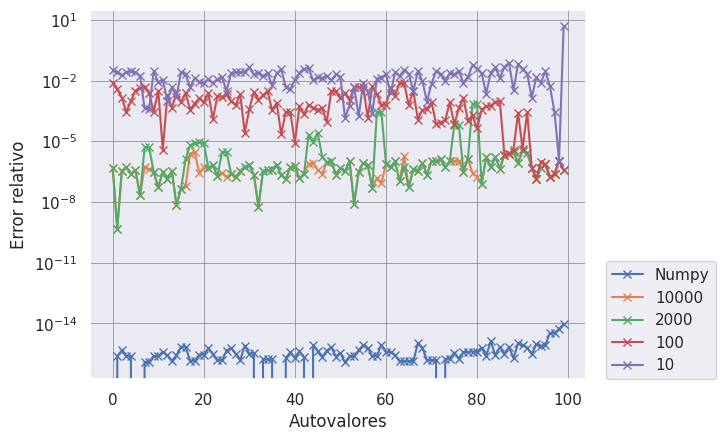

In [74]:
sns.set_theme()

plt.semilogy(err_np1, "-x", label = "Numpy")
plt.semilogy(err_10mil1, "-x", label = "10000")
plt.semilogy(err_2mil1, "-x", label = "2000")
plt.semilogy(err_1001, "-x", label = "100")
plt.semilogy(err_101, "-x", label = "10")

plt.legend(loc=(1.04, 0))
plt.xlabel("Autovalores")
plt.ylabel("Error relativo")
plt.grid(color='grey', linestyle='-', linewidth=0.5)
sns.set_context('talk')
plt.savefig("error.pdf", dpi = 300)
plt.show()

### Repetidos
Para el primer caso el de los autovalores repetidos, lo que se espera ver es que el error entre los autovectores verdaderos y los calculados aumenta para ese tipo de matrices, por ej con la cantidad de repetidos. Podemos ver el error relativo entre los autovalores verdaderos y los calculados también. 
(se puede hacer aleatorio)
Entonces, en este caso, diseñamos una matriz de 10x10, la repetimos 10 veces y en cada vez agregamos un autovalor repetido más. Además, para cada matriz, computamos los autovalores y autovectores para n_iter = 10, 500 y 2000. Para medir error de autovalores utilizamos error relativo en valor absoluto, para poder resumir la distancia entre la matriz de autovectores original y la calculada proponemos utilizar la norma de frobenius de la diferencia entre las dos matrices. 

In [108]:
def create_ground_truth(diag):
    D = np.diag(diag)
    v = np.ones((D.shape[0], 1))
    v = v / np.linalg.norm(v)
    Q = np.eye(D.shape[0]) - 2 * (v @ v.T) 
    M = Q.T @ D @ Q
    sorted_indices = np.argsort(diag)[::-1]
    avals = diag[sorted_indices]
    avecs = Q[:, sorted_indices]
    return M, avals, avecs

def exp(M, n):
    l_np, v_np = np.linalg.eig(M)
    lnp = np.sort(l_np)[::-1]
    vnp = v_np[:, np.argsort(l_np)[::-1]]
    lmil, vmil = eig(M, n, niter = 1_000, eps = 0)
    l100, v100 = eig(M, n, niter = 100, eps = 0)
    l10, v10 = eig(M, n, niter = 10, eps = 0)

    return lnp, vnp, lmil, vmil, l100, v100, l10, v10


def exp2(M, n):
    l_np, v_np = np.linalg.eig(M)
    lnp = np.sort(l_np)[::-1]
    vnp = v_np[:, np.argsort(l_np)[::-1]]
    l1, v1 = eig(M, n, niter = 1, eps = 0)
    l2, v2 = eig(M, n, niter = 2, eps = 0)
    l3, v3 = eig(M, n, niter = 3, eps = 0)
    l4, v4 = eig(M, n, niter = 4, eps = 0)
    l5, v5 = eig(M, n, niter = 5, eps = 0)
    l6, v6 = eig(M, n, niter = 6, eps = 0)
    l7, v7 = eig(M, n, niter = 7, eps = 0)
    l8, v8 = eig(M, n, niter = 8, eps = 0)
    l9, v9 = eig(M, n, niter = 9, eps = 0)
    l10, v10 = eig(M, n, niter = 10, eps = 0)
    return lnp, vnp, l1, v1, l2, v2, l3, v3, l4, v4, l5, v5, l6, v6, l7, v7, l8, v8, l9, v9, l10, v10

In [77]:
d1 = np.array([0.80047905, 0.93911135, 0.04065581, 0.67567172, 0.27656307,
       0.4757645 , 0.53676096, 0.71724223, 0.14714757, 0.65874826])

d2 = np.array([0.80047905, 0.93911135, 0.93911135, 0.67567172, 0.27656307,
       0.4757645 , 0.53676096, 0.71724223, 0.14714757, 0.65874826])

d3 = np.array([0.80047905, 0.93911135, 0.93911135, 0.93911135, 0.27656307,
       0.4757645 , 0.53676096, 0.71724223, 0.14714757, 0.65874826])

d4 = np.array([0.80047905, 0.93911135, 0.93911135, 0.93911135, 0.93911135,
       0.4757645 , 0.53676096, 0.71724223, 0.14714757, 0.65874826])

d5 = np.array([0.80047905, 0.93911135, 0.93911135, 0.93911135, 0.93911135,
       0.93911135, 0.53676096, 0.71724223, 0.14714757, 0.65874826])

d6 = np.array([0.80047905, 0.93911135,  0.93911135,  0.93911135,  0.93911135,
        0.93911135,  0.93911135, 0.71724223, 0.14714757, 0.65874826])

d7 = np.array([0.80047905, 0.93911135,  0.93911135,  0.93911135,  0.93911135,
        0.93911135,  0.93911135,  0.93911135, 0.14714757, 0.65874826])

d8 = np.array([0.80047905, 0.93911135,  0.93911135,  0.93911135,  0.93911135,
        0.93911135,  0.93911135,  0.93911135,  0.93911135, 0.65874826])

d9 = np.array([0.80047905, 0.93911135,  0.93911135,  0.93911135,  0.93911135,
       0.93911135,  0.93911135,  0.93911135,  0.93911135, 0.93911135])

In [78]:
M1, vals1, vecs1 = create_ground_truth(d1)
M2, vals2, vecs2 = create_ground_truth(d2)
M3, vals3, vecs3 = create_ground_truth(d3)
M4, vals4, vecs4 = create_ground_truth(d4)
M5, vals5, vecs5 = create_ground_truth(d5)
M6, vals6, vecs6 = create_ground_truth(d6)
M7, vals7, vecs7 = create_ground_truth(d7)
M8, vals8, vecs8 = create_ground_truth(d8)
M9, vals9, vecs9 = create_ground_truth(d9)

In [107]:
M1

array([[ 0.69101321, -0.1371923 ,  0.04249881, -0.08450437, -0.00468264,
        -0.04452293, -0.05672222, -0.09281848,  0.02120046, -0.08111968],
       [-0.1371923 ,  0.77419259,  0.01477235, -0.11223083, -0.0324091 ,
        -0.07224939, -0.08444868, -0.12054494, -0.006526  , -0.10884614],
       [ 0.04249881,  0.01477235,  0.23511927,  0.06746027,  0.147282  ,
         0.10744172,  0.09524243,  0.05914617,  0.1731651 ,  0.07084497],
       [-0.08450437, -0.11223083,  0.06746027,  0.61612881,  0.02027882,
        -0.01956146, -0.03176076, -0.06785701,  0.04616192, -0.05615822],
       [-0.00468264, -0.0324091 ,  0.147282  ,  0.02027882,  0.37666362,
         0.06026027,  0.04806097,  0.01196472,  0.12598365,  0.02366351],
       [-0.04452293, -0.07224939,  0.10744172, -0.01956146,  0.06026027,
         0.49618448,  0.00822069, -0.02787557,  0.08614337, -0.01617677],
       [-0.05672222, -0.08444868,  0.09524243, -0.03176076,  0.04806097,
         0.00822069,  0.53278236, -0.04007486

In [84]:
matrix_list = [M1, M2, M3, M4, M5, M6, M7, M8, M9]
vals_list = [vals1, vals2, vals3, vals4, vals5, vals6, vals7, vals8, vals9]
vecs_list = [vecs1, vecs2, vecs3, vecs4, vecs5, vecs6, vecs7, vecs8, vecs9]

res_dict = {}
for idx, matrix in enumerate(matrix_list):
    n = 10
    lnp, vnp, lmil, vmil, l100, v100, l10, v10 = exp(matrix, n)
    gt_vals = vals_list[idx]
    gt_vecs = vecs_list[idx]
    id = f"M{idx+1}"
    error_relativo_np = np.abs((gt_vals-lnp)/gt_vals)
    error_relativo10 = np.abs((gt_vals-l10)/gt_vals)
    error_relativo100 = np.abs((gt_vals-l100)/gt_vals)
    error_relativomil = np.abs((gt_vals-lmil)/gt_vals)
    frobenius_np = np.linalg.norm(np.abs(gt_vecs) - np.abs(vnp), 'fro')
    frobenius_10 = np.linalg.norm(np.abs(gt_vecs) - np.abs(v10), 'fro')
    frobenius_100 = np.linalg.norm(np.abs(gt_vecs) - np.abs(v100), 'fro')
    frobenius_mil = np.linalg.norm(np.abs(gt_vecs) - np.abs(vmil), 'fro')
    res_dict[id] = {'enp':error_relativo_np, 'e10': error_relativo10, 'e100': error_relativo100, 'emil': error_relativomil, 
                    'fnp': frobenius_np, 'f10': frobenius_10, 'f100': frobenius_100, 'fmil': frobenius_mil}

In [86]:
e1 = [res_dict['M1']['fnp'], res_dict['M1']['f10'], res_dict['M1']['f100'], res_dict['M1']['fmil']]
e2 = [res_dict['M2']['fnp'], res_dict['M2']['f10'], res_dict['M2']['f100'], res_dict['M2']['fmil']]
e3 = [res_dict['M3']['fnp'], res_dict['M3']['f10'], res_dict['M3']['f100'], res_dict['M3']['fmil']]
e4 = [res_dict['M4']['fnp'], res_dict['M4']['f10'], res_dict['M4']['f100'], res_dict['M4']['fmil']]
e5 = [res_dict['M5']['fnp'], res_dict['M5']['f10'], res_dict['M5']['f100'], res_dict['M5']['fmil']]
e6 = [res_dict['M6']['fnp'], res_dict['M6']['f10'], res_dict['M6']['f100'], res_dict['M6']['fmil']]
e7 = [res_dict['M7']['fnp'], res_dict['M7']['f10'], res_dict['M7']['f100'], res_dict['M7']['fmil']]
e8 = [res_dict['M8']['fnp'], res_dict['M8']['f10'], res_dict['M8']['f100'], res_dict['M8']['fmil']]
e9 = [res_dict['M9']['fnp'], res_dict['M9']['f10'], res_dict['M9']['f100'], res_dict['M9']['fmil']]

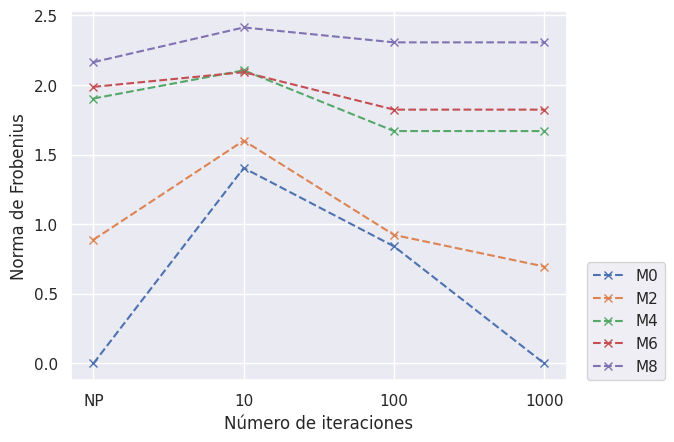

In [89]:
sns.set_theme() 
plt.plot(e1, "--x", label = "M0")
plt.plot(e2, "--x", label = "M2")
#plt.plot(e3, "-x", label = "M3")
plt.plot(e4, "--x", label = "M4")
#plt.plot(e5, "-x", label = "M5")
plt.plot(e6, "--x", label = "M6")
#plt.plot(e7, "-x", label = "M7")
plt.plot(e8, "--x", label = "M8")
#plt.plot(e9, "-x", label = "M9")

plt.legend(loc=(1.04, 0))
plt.xlabel("Número de iteraciones")
plt.ylabel("Norma de Frobenius")

custom_labels = ["NP", "10", "100", "1000"]
plt.xticks([0, 1, 2, 3], custom_labels)
plt.savefig("frobenius.svg", dpi = 300)

### Parecidos

In [109]:
diago = np.array([1,  3,  6,  10,  4])
diagp = np.array([1,  3,  2.999,  10,  4])

MO, valsO, vecsO = create_ground_truth(diago)
MP, valsP, vecsP = create_ground_truth(diagp)

In [110]:
matrix_list = [MO, MP]
vals_list = [valsO, valsO]
vecs_list = [vecsP, vecsP]

res_dict = {}
n=5
for idx, matrix in enumerate(matrix_list):
    lnp, vnp, l1, v1, l2, v2, l3, v3, l4, v4, l5, v5, l6, v6, l7, v7, l8, v8, l9, v9, l10, v10 = exp2(matrix, n)
    gt_vals = vals_list[idx]
    gt_vecs = vecs_list[idx]
    id = f"M{idx+1}"
    error_relativo_np = np.abs((gt_vals-lnp)/gt_vals)
    error_relativo1 = np.abs((gt_vals-l1)/gt_vals)
    error_relativo2 = np.abs((gt_vals-l2)/gt_vals)
    error_relativo3 = np.abs((gt_vals-l3)/gt_vals)
    error_relativo4 = np.abs((gt_vals-l4)/gt_vals)
    error_relativo5 = np.abs((gt_vals-l5)/gt_vals)
    error_relativo6 = np.abs((gt_vals-l6)/gt_vals)
    error_relativo7 = np.abs((gt_vals-l7)/gt_vals)
    error_relativo8 = np.abs((gt_vals-l8)/gt_vals)
    error_relativo9 = np.abs((gt_vals-l9)/gt_vals)
    error_relativo10 = np.abs((gt_vals-l10)/gt_vals)

    res_dict[id] = {'enp':error_relativo_np, 'e1': error_relativo1, 'e2': error_relativo2, 'e3': error_relativo3, 
                    'e4': error_relativo4, 'e5': error_relativo5, 'e6': error_relativo6, 'e7': error_relativo7, 
                    'e8': error_relativo8, 'e9': error_relativo9, 'e10': error_relativo10}

In [118]:
aerrores_vals_original3 = [res_dict['M1']['enp'][3], res_dict['M1']['e1'][3], res_dict['M1']['e2'][3], res_dict['M1']['e3'][3], 
                          res_dict['M1']['e4'][3], res_dict['M1']['e5'][3], res_dict['M1']['e6'][3], res_dict['M1']['e7'][3],
                            res_dict['M1']['e8'][3], res_dict['M1']['e9'][3], res_dict['M1']['e10'][3]]
aerrores_vals_parecidos3 = [res_dict['M2']['enp'][3], res_dict['M2']['e1'][3], res_dict['M2']['e2'][3], res_dict['M2']['e3'][3],
                           res_dict['M2']['e4'][3], res_dict['M2']['e5'][3], res_dict['M2']['e6'][3], res_dict['M2']['e7'][3],
                            res_dict['M2']['e8'][3], res_dict['M2']['e9'][3], res_dict['M2']['e10'][3]]

aerrores_vals_original2 = [res_dict['M1']['enp'][2], res_dict['M1']['e1'][2], res_dict['M1']['e2'][2], res_dict['M1']['e3'][2], 
                          res_dict['M1']['e4'][2], res_dict['M1']['e5'][2], res_dict['M1']['e6'][2], res_dict['M1']['e7'][2],
                            res_dict['M1']['e8'][2], res_dict['M1']['e9'][2], res_dict['M1']['e10'][2]]
aerrores_vals_parecidos2 = [res_dict['M2']['enp'][2], res_dict['M2']['e1'][2], res_dict['M2']['e2'][2], res_dict['M2']['e3'][2],
                           res_dict['M2']['e4'][2], res_dict['M2']['e5'][2], res_dict['M2']['e6'][2], res_dict['M2']['e7'][2],
                            res_dict['M2']['e8'][2], res_dict['M2']['e9'][2], res_dict['M2']['e10'][2]]


Text(0, 0.5, 'Error relativo')

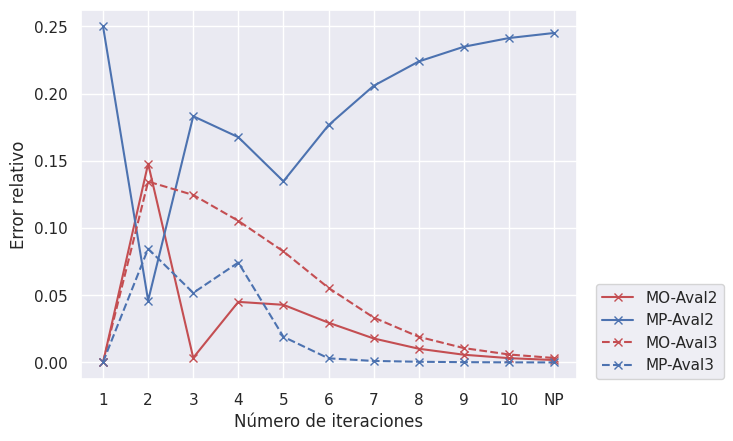

In [125]:
sns.set_theme() 
plt.plot(aerrores_vals_original2, "r-x", label = "MO-Aval2")
plt.plot(aerrores_vals_parecidos2, "b-x", label = "MP-Aval2")
plt.plot(aerrores_vals_original3, "r--x", label = "MO-Aval3")
plt.plot(aerrores_vals_parecidos3, "b--x", label = "MP-Aval3")

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10], [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 'NP'])
plt.legend(loc=(1.04, 0))
plt.xlabel("Número de iteraciones")
plt.ylabel("Error relativo")

In [99]:
eO = [res_dict['M1']['fnp'], res_dict['M1']['f10'], res_dict['M1']['f100'], res_dict['M1']['fmil']]
eP = [res_dict['M2']['fnp'], res_dict['M2']['f10'], res_dict['M2']['f100'], res_dict['M2']['fmil']]


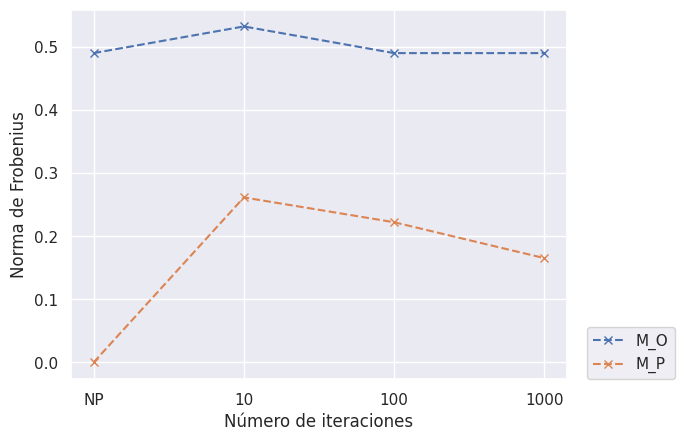

In [100]:
sns.set_theme() 
plt.plot(eO, "--x", label = "M_O")
plt.plot(eP, "--x", label = "M_P")


plt.legend(loc=(1.04, 0))
plt.xlabel("Número de iteraciones")
plt.ylabel("Norma de Frobenius")

custom_labels = ["NP", "10", "100", "1000"]
plt.xticks([0, 1, 2, 3], custom_labels)
plt.savefig("frobenius.svg", dpi = 300)